In [1]:
# 导入用的Python modules
import numpy as np
import matplotlib.pyplot as plt
import sys
import caffe
import os

os.chdir('../examples')

In [2]:
# 导入caffe layer 和 params
from caffe import layers as L, params as P
def lenet(lmdb, batch_size):
    n = caffe.NetSpec()
    n.data, n.label = L.Data(batch_size = batch_size, backend = P.Data.LMDB, source = lmdb, transform_param = dict
                            (scale=1./255), ntop = 2)
    n.conv1 = L.Convolution(n.data, kernel_size = 5, num_output = 20, weight_filler=dict(type='xavier'))
    n.pool1 = L.Pooling(n.conv1, kernel_size = 2, stride = 2, pool = P.Pooling.MAX)
    n.conv2 = L.Convolution(n.pool1, kernel_size = 5, num_output = 50, weight_filler=dict(type='xavier'))
    n.pool2 = L.Pooling(n.conv2, kernel_size = 2, stride = 2, pool = P.Pooling.MAX)
    n.fc1 = L.InnerProduct(n.pool2, num_output = 500, weight_filler = dict(type='xavier'))
    n.relu1 = L.ReLU(n.fc1, in_place = True)
    n.score = L.InnerProduct(n.relu1, num_output = 10, weight_filler = dict(type = 'xavier'))
    n.loss = L.SoftmaxWithLoss(n.score, n.label)
    
    return n.to_proto()

# python with 语法用于打开文件读写后自动关闭文件
with open('mnist/lenet_auto_train.prototxt', 'w') as f:
    f.write(str(lenet('mnist/mnist_train_lmdb', 64)))

with open('mnist/lenet_auto_test.prototxt', 'w') as f:
    f.write(str(lenet('mnist/mnist_test_lmdb', 100)))
    
print(os.getcwd())

/home/allen/sdb1/workspace/open_source/caffe/examples


In [3]:
# check save network
!cat mnist/lenet_auto_train.prototxt

layer {
  name: "data"
  type: "Data"
  top: "data"
  top: "label"
  transform_param {
    scale: 0.00392156862745
  }
  data_param {
    source: "mnist/mnist_train_lmdb"
    batch_size: 64
    backend: LMDB
  }
}
layer {
  name: "conv1"
  type: "Convolution"
  bottom: "data"
  top: "conv1"
  convolution_param {
    num_output: 20
    kernel_size: 5
    weight_filler {
      type: "xavier"
    }
  }
}
layer {
  name: "pool1"
  type: "Pooling"
  bottom: "conv1"
  top: "pool1"
  pooling_param {
    pool: MAX
    kernel_size: 2
    stride: 2
  }
}
layer {
  name: "conv2"
  type: "Convolution"
  bottom: "pool1"
  top: "conv2"
  convolution_param {
    num_output: 50
    kernel_size: 5
    weight_filler {
      type: "xavier"
    }
  }
}
layer {
  name: "pool2"
  type: "Pooling"
  bottom: "conv2"
  top: "pool2"
  pooling_param {
    pool: MAX
    kernel_size: 2
    stride: 2
  }
}
layer {
  name: "fc1"
  type: "InnerProduct"
  bottom: "pool2"
  top: "fc1"
  inner_product_param {
    num_out

In [4]:
# check solver params
!cat mnist/lenet_auto_solver.prototxt

# The train/test net protocol buffer definition
train_net: "mnist/lenet_auto_train.prototxt"
test_net: "mnist/lenet_auto_test.prototxt"
# test_iter specifies how many forward passes the test should carry out.
# In the case of MNIST, we have test batch size 100 and 100 test iterations,
# covering the full 10,000 testing images.
test_iter: 100
# Carry out testing every 500 training iterations.
test_interval: 500
# The base learning rate, momentum and the weight decay of the network.
base_lr: 0.01
momentum: 0.9
weight_decay: 0.0005
# The learning rate policy
lr_policy: "inv"
gamma: 0.0001
power: 0.75
# Display every 100 iterations
display: 100
# The maximum number of iterations
max_iter: 10000
# snapshot intermediate results
snapshot: 5000
snapshot_prefix: "mnist/lenet"


In [5]:
# init caffe settin
caffe.set_device(0)
caffe.set_mode_gpu()

#load solver and init 
solver = None
solver = caffe.SGDSolver('mnist/lenet_auto_solver.prototxt')

In [6]:
# print all output dims
[(k, v.data.shape) for k, v in solver.net.blobs.items()]

[('data', (64, 1, 28, 28)),
 ('label', (64,)),
 ('conv1', (64, 20, 24, 24)),
 ('pool1', (64, 20, 12, 12)),
 ('conv2', (64, 50, 8, 8)),
 ('pool2', (64, 50, 4, 4)),
 ('fc1', (64, 500)),
 ('score', (64, 10)),
 ('loss', ())]

In [7]:
# forward
solver.net.forward() # train net
solver.test_nets[0].forward()

{'loss': array(2.469578742980957, dtype=float32)}

In [24]:
plt.imshow(solver.net.blobs['data'].data[:8, 0].transpose(1, 0, 2).reshape(28, 8 * 28));
print(solver.net.blobs['label'].data[:8])
plt.axis('off')
#plt.show()

[ 1.  6.  3.  4.  5.  9.  1.  3.]


(-0.5, 223.5, 27.5, -0.5)

In [25]:
plt.imshow(solver.test_nets[0].blobs['data'].data[:8, 0].transpose(1, 0, 2).reshape(28, 8 * 28));
print(solver.test_nets[0].blobs['label'].data[:8])
plt.axis('off')
#plt.show()

[ 7.  2.  1.  0.  4.  1.  4.  9.]


(-0.5, 223.5, 27.5, -0.5)

In [26]:
solver.step(1)

In [27]:
plt.imshow(solver.net.params['conv1'][0].diff[:, 0].reshape(4, 5, 5, 5).transpose(0, 2, 1 ,3 ).reshape(4*5, 5 * 5))
plt.axis('off')
#plt.show()

(-0.5, 24.5, 19.5, -0.5)

In [31]:
niter = 200
test_interval = 25

# save train loss
train_loss = np.zeros(niter)
test_acc = np.zeros(int(np.ceil(niter / test_interval)))
output = np.zeros((niter, 8 , 10))

# main train loop
for it in range(niter):
    solver.step(1)
    train_loss[it] = solver.net.blobs['loss'].data
    
    solver.test_nets[0].forward(start = 'conv1')
    output[it] = solver.test_nets[0].blobs['score'].data[:8]
    
    if it % test_interval == 0:
        print 'Iteration,', it, 'testing...'
        correct = 0;
        for test_in in range(100):
            solver.test_nets[0].forward()
            correct += sum(solver.test_nets[0].blobs['score'].data.argmax(1) == solver.test_nets[0].blobs['label'].data)
        
        test_acc[it // test_interval] = correct / 1e4

Iteration, 0 testing...
Iteration, 25 testing...
Iteration, 50 testing...
Iteration, 75 testing...
Iteration, 100 testing...
Iteration, 125 testing...
Iteration, 150 testing...
Iteration, 175 testing...


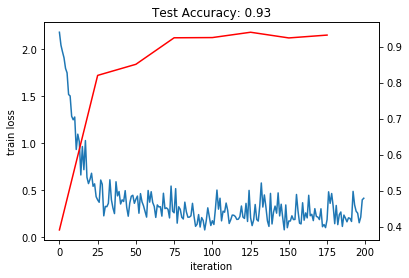

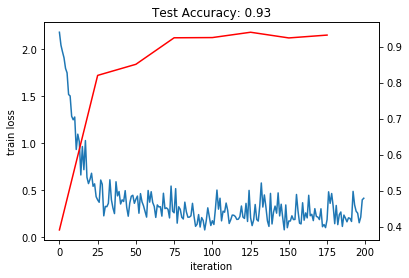

In [37]:
_, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(np.arange(niter), train_loss)
ax2.plot(test_interval * np.arange(len(test_acc)), test_acc, 'r')
ax1.set_xlabel('iteration')
ax1.set_ylabel('train loss')
ax2.set_xlabel('test accuracy')
ax2.set_title('Test Accuracy: {:.2f}'.format(test_acc[-1]))
plt.show()

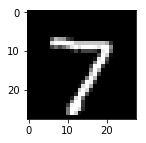

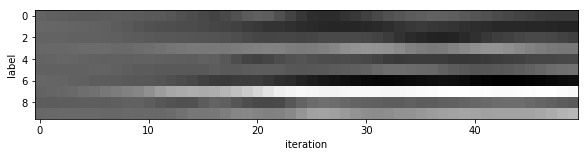

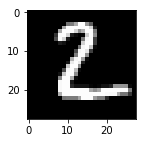

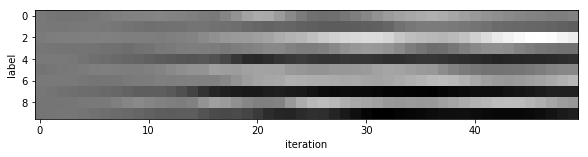

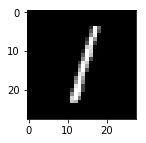

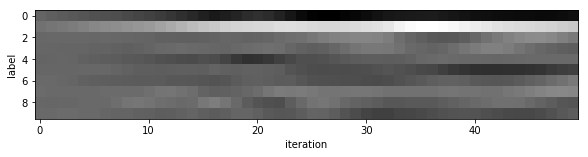

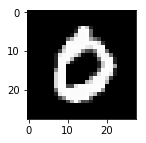

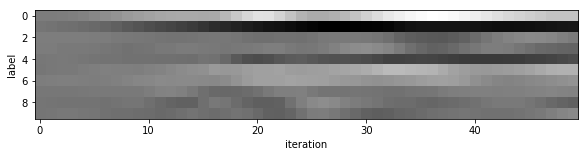

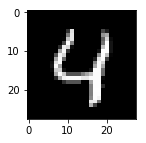

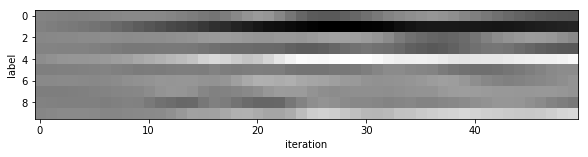

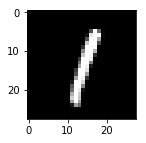

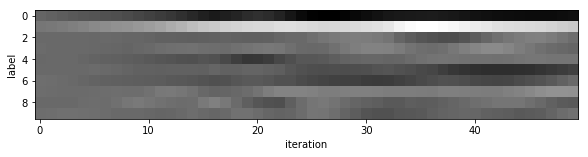

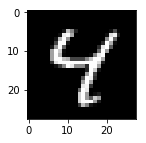

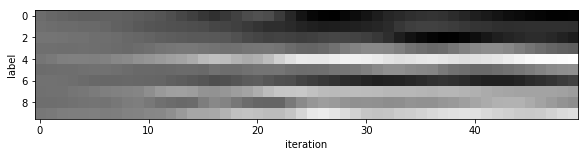

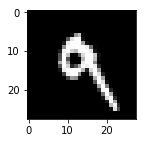

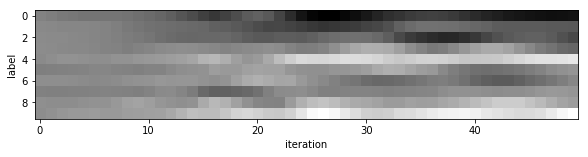

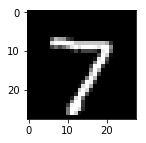

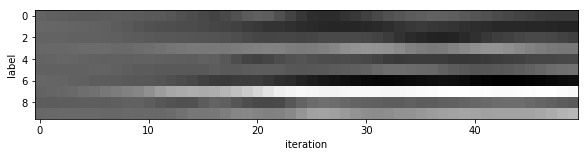

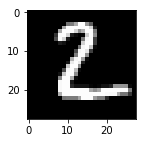

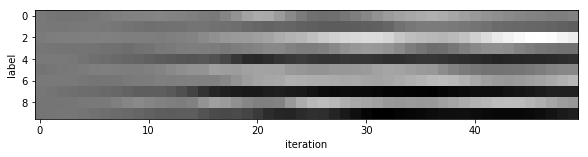

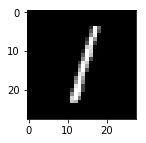

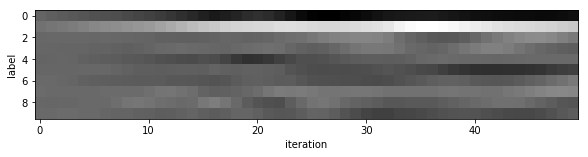

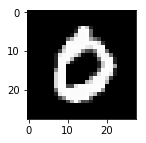

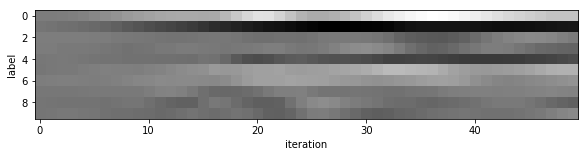

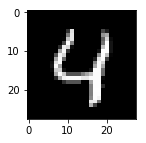

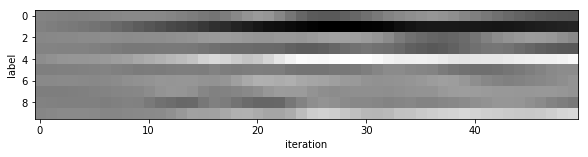

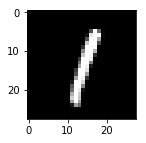

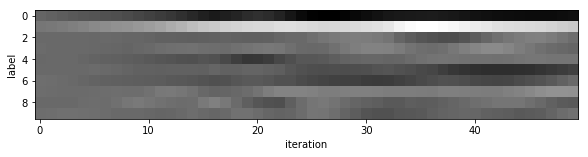

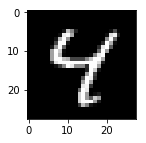

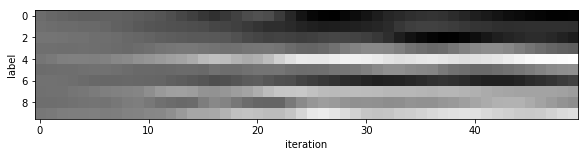

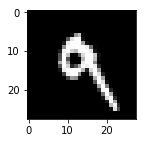

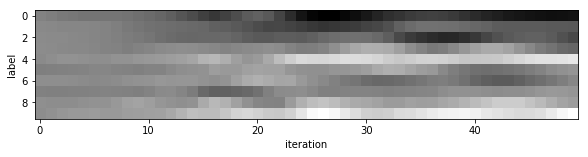

In [40]:
for i in range(8):
    plt.figure(figsize=(2, 2))
    plt.imshow(solver.test_nets[0].blobs['data'].data[i, 0], cmap='gray')
    plt.figure(figsize=(10, 2))
    plt.imshow(output[:50, i].T, interpolation='nearest', cmap='gray')
    plt.xlabel('iteration')
    plt.ylabel('label')
    plt.show()


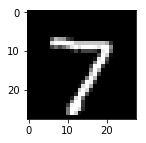

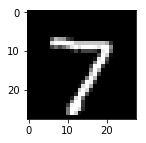

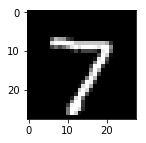

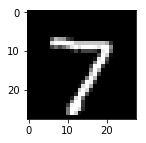

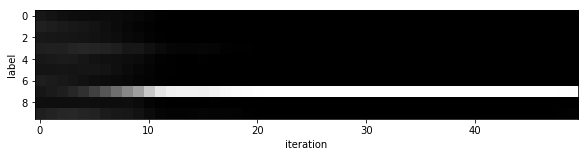

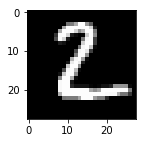

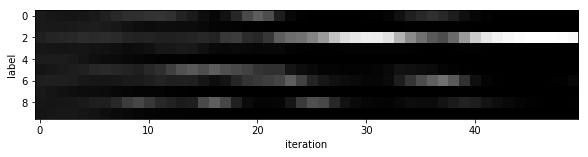

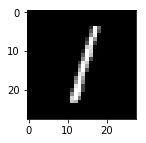

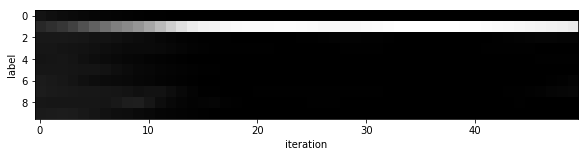

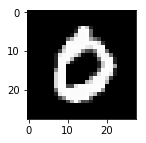

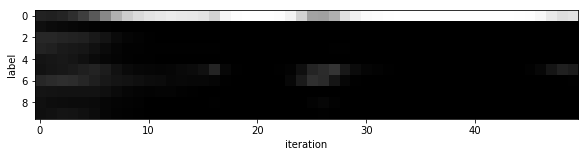

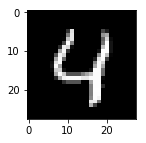

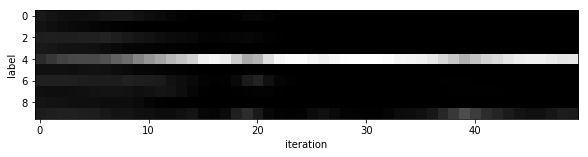

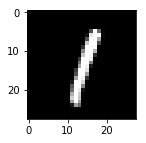

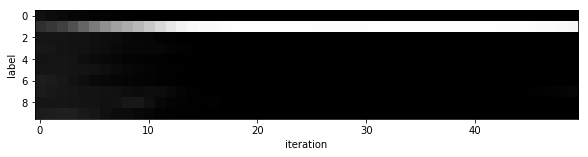

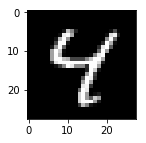

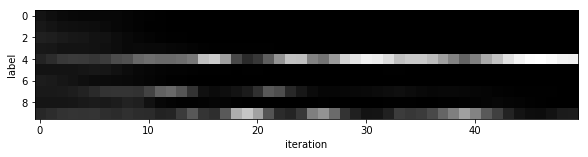

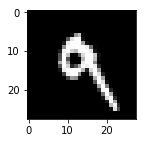

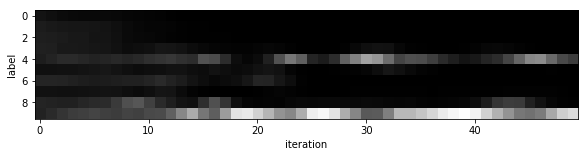

In [44]:
import math
for i in range(8):
    plt.figure(figsize=(2, 2))
    plt.imshow(solver.test_nets[0].blobs['data'].data[i, 0], cmap='gray')
    plt.figure(figsize=(10, 2))
    plt.imshow(np.exp(output[:50, i].T) / np.exp(output[:50, i].T).sum(0), interpolation='nearest', cmap='gray')
    plt.xlabel('iteration')
    plt.ylabel('label')
    plt.show()


Iteration 0 testing...
Iteration 25 testing...
Iteration 50 testing...
Iteration 75 testing...
Iteration 100 testing...
Iteration 125 testing...
Iteration 150 testing...
Iteration 175 testing...
Iteration 200 testing...
Iteration 225 testing...


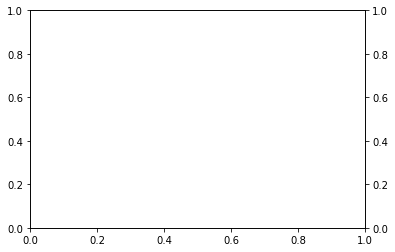

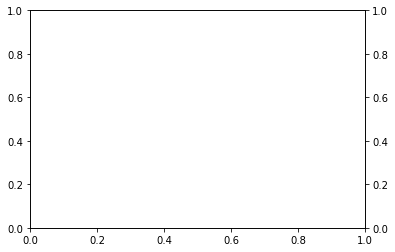

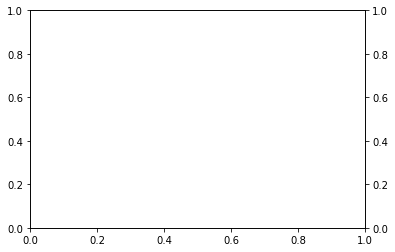

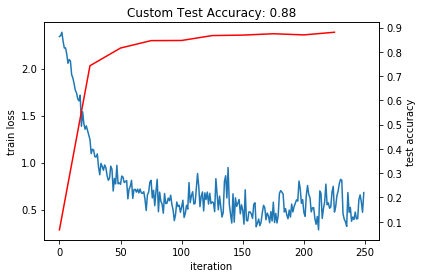

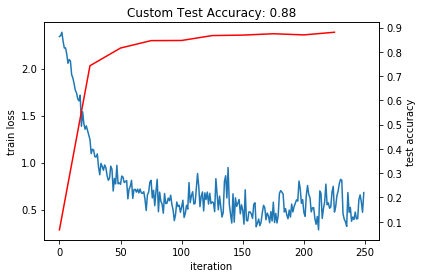

In [51]:
train_net_path = 'mnist/custom_auto_train.prototxt'
test_net_path = 'mnist/custom_auto_test.prototxt'
solver_config_path = 'mnist/custom_auto_solver.prototxt'

### define net
def custom_net(lmdb, batch_size):
    # define your own net!
    n = caffe.NetSpec()
    
    # keep this data layer for all networks
    n.data, n.label = L.Data(batch_size=batch_size, backend=P.Data.LMDB, source=lmdb,
                             transform_param=dict(scale=1./255), ntop=2)
    
    # EDIT HERE to try different networks
    # this single layer defines a simple linear classifier
    # (in particular this defines a multiway logistic regression)
    n.score =   L.InnerProduct(n.data, num_output=10, weight_filler=dict(type='xavier'))
    
    # EDIT HERE this is the LeNet variant we have already tried
    # n.conv1 = L.Convolution(n.data, kernel_size=5, num_output=20, weight_filler=dict(type='xavier'))
    # n.pool1 = L.Pooling(n.conv1, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    # n.conv2 = L.Convolution(n.pool1, kernel_size=5, num_output=50, weight_filler=dict(type='xavier'))
    # n.pool2 = L.Pooling(n.conv2, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    # n.fc1 =   L.InnerProduct(n.pool2, num_output=500, weight_filler=dict(type='xavier'))
    # EDIT HERE consider L.ELU or L.Sigmoid for the nonlinearity
    # n.relu1 = L.ReLU(n.fc1, in_place=True)
    # n.score =   L.InnerProduct(n.fc1, num_output=10, weight_filler=dict(type='xavier'))
    
    # keep this loss layer for all networks
    n.loss =  L.SoftmaxWithLoss(n.score, n.label)
    
    return n.to_proto()

with open(train_net_path, 'w') as f:
    f.write(str(custom_net('mnist/mnist_train_lmdb', 64)))    
with open(test_net_path, 'w') as f:
    f.write(str(custom_net('mnist/mnist_test_lmdb', 100)))

### define solver
from caffe.proto import caffe_pb2
s = caffe_pb2.SolverParameter()

# Set a seed for reproducible experiments:
# this controls for randomization in training.
s.random_seed = 0xCAFFE

# Specify locations of the train and (maybe) test networks.
s.train_net = train_net_path
s.test_net.append(test_net_path)
s.test_interval = 500  # Test after every 500 training iterations.
s.test_iter.append(100) # Test on 100 batches each time we test.

s.max_iter = 10000     # no. of times to update the net (training iterations)
 
# EDIT HERE to try different solvers
# solver types include "SGD", "Adam", and "Nesterov" among others.
s.type = "SGD"

# Set the initial learning rate for SGD.
s.base_lr = 0.01  # EDIT HERE to try different learning rates
# Set momentum to accelerate learning by
# taking weighted average of current and previous updates.
s.momentum = 0.9
# Set weight decay to regularize and prevent overfitting
s.weight_decay = 5e-4

# Set `lr_policy` to define how the learning rate changes during training.
# This is the same policy as our default LeNet.
s.lr_policy = 'inv'
s.gamma = 0.0001
s.power = 0.75
# EDIT HERE to try the fixed rate (and compare with adaptive solvers)
# `fixed` is the simplest policy that keeps the learning rate constant.
# s.lr_policy = 'fixed'

# Display the current training loss and accuracy every 1000 iterations.
s.display = 1000

# Snapshots are files used to store networks we've trained.
# We'll snapshot every 5K iterations -- twice during training.
s.snapshot = 5000
s.snapshot_prefix = 'mnist/custom_net'

# Train on the GPU
s.solver_mode = caffe_pb2.SolverParameter.GPU

# Write the solver to a temporary file and return its filename.
with open(solver_config_path, 'w') as f:
    f.write(str(s))

### load the solver and create train and test nets
solver = None  # ignore this workaround for lmdb data (can't instantiate two solvers on the same data)
solver = caffe.get_solver(solver_config_path)

### solve
niter = 250  # EDIT HERE increase to train for longer
test_interval = niter / 10
# losses will also be stored in the log
train_loss = np.zeros(niter)
test_acc = np.zeros(int(np.ceil(niter / test_interval)))

# the main solver loop
for it in range(niter):
    solver.step(1)  # SGD by Caffe
    
    # store the train loss
    train_loss[it] = solver.net.blobs['loss'].data
    
    # run a full test every so often
    # (Caffe can also do this for us and write to a log, but we show here
    #  how to do it directly in Python, where more complicated things are easier.)
    if it % test_interval == 0:
        print 'Iteration', it, 'testing...'
        correct = 0
        for test_it in range(100):
            solver.test_nets[0].forward()
            correct += sum(solver.test_nets[0].blobs['score'].data.argmax(1)
                           == solver.test_nets[0].blobs['label'].data)
        test_acc[it // test_interval] = correct / 1e4

_, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(np.arange(niter), train_loss)
ax2.plot(test_interval * np.arange(len(test_acc)), test_acc, 'r')
ax1.set_xlabel('iteration')
ax1.set_ylabel('train loss')
ax2.set_ylabel('test accuracy')
ax2.set_title('Custom Test Accuracy: {:.2f}'.format(test_acc[-1]))
plt.show()